# ChessML Netz

This neural network based on PyTorch will try to classifiy chess pieces from photos taken from the top of a chessboard.

In [1]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import random
import time
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from PIL import Image

## Defining all possible classes

bb = Black Bishop
bk = Black King
bn = Black Knight
bp = Black Pawn
bq = Black Queen
br = Black Rook
...

In [2]:
CLASSES = ["bb", "bk", "bn", "bp", "bq", "br", "wb", "wk", "wn", "wp", "wq", "wr", "empty"]

## Define a normalization function for the analyzed data

The values are recommended by a PyTorch tutorial (https://youtu.be/32lHVbT09h8).

In [3]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

## Defining the Neural Network

In [4]:
class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        # Defining the convolutional layers of the net
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=3)
        self.conv4 = nn.Conv2d(24, 48, kernel_size=3)
        self.conv5 = nn.Conv2d(48, 96, kernel_size=3)

        # Defining dropout layer to prevent from memorizing
        self.dropout1 = nn.Dropout()
        self.dropout2 = nn.Dropout()

        # Defining the fully connected layers of the net
        self.fc1 = nn.Linear(384, 64)  # 96*2*2 = 384
        self.fc2 = nn.Linear(64, 13)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)  # Relu because it's famous

        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv4(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv5(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.dropout1(x)

        x = x.view(-1, 384)  # Convert 2d data to 1d

        x = self.fc1(x)
        x = self.dropout2(x)
        x = F.relu(x)

        x = self.fc2(x)

        return torch.sigmoid(x)


## Training

In [5]:
def train(model, epoch, train_data, optimizer, criterion):
    model.train()    
    running_loss = 0.0
    for i, t_data in enumerate(train_data):
        data, target = t_data
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('Epoch: %2d [%d/%5d] loss: %.3f' % (epoch, i + 1, len(train_data), running_loss / 100))
            running_loss = 0.0


## Validation

In [6]:
def validate(model, validation_data, criterion, epoch=0):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in validation_data:
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()

            out = model(data)
            loss += criterion(out, target).item()
            _, prediction = torch.max(out.data, 1)
            total += target.size(0)

            if torch.cuda.is_available():
                correct += prediction.eq(target).sum().cpu().item()
            else:
                correct += prediction.eq(target).sum().item()

    loss = loss / total
    print("\nValidation")
    print("###################################")
    print("Epoch", epoch)
    print("Average loss:", loss)
    print("Accuracy: %.2f" % (100. * correct / total))
    print("###################################\n\n")


## Testing

In [7]:
def test(model, test_files):
    model.eval()
    orig_images = []
    images = []
    labels = []
    for i in range(4):
        file = random.choice(test_files)
        test_files.remove(file)
        img = Image.open(file[0])
        images.append(transform(img))
        orig_images.append(test_transform(img))
        labels.append(file[1])        
        
    images = torch.stack(images)
    orig_images = torch.stack(orig_images)
    
    out = model(images)
    
    _, predicted = torch.max(out, 1)

    imshow(torchvision.utils.make_grid(orig_images))
    print('   Actual: ', ' '.join('%5s' % CLASSES[labels[j]] for j in range(4)))
    print('Predicted: ', ' '.join('%5s' % CLASSES[predicted[j]] for j in range(4)))


## Helper functions

At first all available files are added to a file list. In addition the label of the file will be generated and added to the list.

In [8]:
def read_files(path):
    file_list = []
    for d in os.listdir(path):
        if os.path.isdir(os.path.join(path, d)):
            for f in os.listdir(os.path.join(path, d)):
                file_list.append([os.path.join(path, d, f), CLASSES.index(d)])
    return file_list

Generating tensors from the file list, we just created. All files get mixed up randomly.

In [9]:
def generate_tensors(file_list, batch_size):
    data = []
    data_list = []
    label_list = []
    files_count = len(file_list)
    for i in range(files_count):
        file = random.choice(file_list)
        file_list.remove(file)
        
        img = Image.open(file[0])  # Index 0: filename, Index 1: label
        img_tensor = transform(img)
        data_list.append(img_tensor)
        label_list.append(file[1])
        
        if len(data_list) >= batch_size:
            data.append((torch.stack(data_list), torch.tensor(label_list)))
            data_list = []
            label_list = []

            #Statistics
            print("Loaded batch", len(data), "of", int(files_count / batch_size))
            print("Percentage Done: %.2f" % (len(data) / int(files_count / batch_size) * 100))
    return data


In [10]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


The save model function will save the state of a model after a specific epoch. 

In [11]:
def save_model(model, epoch):
    torch.save(model.state_dict(), "model/chess-net_{}.pt".format(epoch))
    print("Checkpoint saved")

## Main

Training and evaluating the ChessNet

In [12]:
def main():
    print("Loading Training Data")
    train_files = read_files("data/train_augmented")
    train_data = generate_tensors(train_files, 4)

    print("Loading Validation Data")
    validation_files = read_files("data/validation_augmented")
    validation_data = generate_tensors(validation_files, 4)
    
    print("Loading Test Data")
    test_files = read_files("data/validation_augmented")

    model = ChessNet()
    
    # Activate cuda support if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Check if model is already available
    # if os.path.isfile("model/chess-net.pt"):
    #    model = torch.load("model/chess-net.pt")

    # Defining the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Defining the loss function
    criterion = nn.CrossEntropyLoss()
    
    # Start training
    epochs = 5
    start = time.time()
    print("Starting training for %s epochs on %s" % (epochs, time.ctime()))
    for epoch in range(epochs + 1):
        train(model, epoch, train_data, optimizer, criterion)
        validate(model, validation_data, criterion, epoch)
        save_model(model, epoch)
    end = time.time()
    print("Training of the neuroal network done.")
    print("Time spent:", end-start, "s")
    
    # Testing the NN
    print("\nTest:")
    test(model, test_files)

Loading Training Data
Loaded batch 1 of 5650
Percentage Done: 0.017699115044247787 %
Loaded batch 2 of 5650
Percentage Done: 0.035398230088495575 %
Loaded batch 3 of 5650
Percentage Done: 0.05309734513274337 %
Loaded batch 4 of 5650
Percentage Done: 0.07079646017699115 %
Loaded batch 5 of 5650
Percentage Done: 0.08849557522123894 %
Loaded batch 6 of 5650
Percentage Done: 0.10619469026548674 %
Loaded batch 7 of 5650
Percentage Done: 0.12389380530973451 %
Loaded batch 8 of 5650
Percentage Done: 0.1415929203539823 %
Loaded batch 9 of 5650
Percentage Done: 0.1592920353982301 %
Loaded batch 10 of 5650
Percentage Done: 0.17699115044247787 %
Loaded batch 11 of 5650
Percentage Done: 0.19469026548672566 %
Loaded batch 12 of 5650
Percentage Done: 0.21238938053097348 %
Loaded batch 13 of 5650
Percentage Done: 0.2300884955752212 %
Loaded batch 14 of 5650
Percentage Done: 0.24778761061946902 %
Loaded batch 15 of 5650
Percentage Done: 0.2654867256637168 %
Loaded batch 16 of 5650
Percentage Done: 0.2

Loaded batch 141 of 5650
Percentage Done: 2.495575221238938 %
Loaded batch 142 of 5650
Percentage Done: 2.5132743362831858 %
Loaded batch 143 of 5650
Percentage Done: 2.5309734513274336 %
Loaded batch 144 of 5650
Percentage Done: 2.5486725663716814 %
Loaded batch 145 of 5650
Percentage Done: 2.566371681415929 %
Loaded batch 146 of 5650
Percentage Done: 2.584070796460177 %
Loaded batch 147 of 5650
Percentage Done: 2.601769911504425 %
Loaded batch 148 of 5650
Percentage Done: 2.6194690265486726 %
Loaded batch 149 of 5650
Percentage Done: 2.6371681415929205 %
Loaded batch 150 of 5650
Percentage Done: 2.6548672566371683 %
Loaded batch 151 of 5650
Percentage Done: 2.672566371681416 %
Loaded batch 152 of 5650
Percentage Done: 2.6902654867256635 %
Loaded batch 153 of 5650
Percentage Done: 2.7079646017699117 %
Loaded batch 154 of 5650
Percentage Done: 2.7256637168141595 %
Loaded batch 155 of 5650
Percentage Done: 2.743362831858407 %
Loaded batch 156 of 5650
Percentage Done: 2.761061946902655 %

Loaded batch 279 of 5650
Percentage Done: 4.938053097345133 %
Loaded batch 280 of 5650
Percentage Done: 4.95575221238938 %
Loaded batch 281 of 5650
Percentage Done: 4.9734513274336285 %
Loaded batch 282 of 5650
Percentage Done: 4.991150442477876 %
Loaded batch 283 of 5650
Percentage Done: 5.008849557522124 %
Loaded batch 284 of 5650
Percentage Done: 5.0265486725663715 %
Loaded batch 285 of 5650
Percentage Done: 5.04424778761062 %
Loaded batch 286 of 5650
Percentage Done: 5.061946902654867 %
Loaded batch 287 of 5650
Percentage Done: 5.079646017699115 %
Loaded batch 288 of 5650
Percentage Done: 5.097345132743363 %
Loaded batch 289 of 5650
Percentage Done: 5.11504424778761 %
Loaded batch 290 of 5650
Percentage Done: 5.132743362831858 %
Loaded batch 291 of 5650
Percentage Done: 5.150442477876107 %
Loaded batch 292 of 5650
Percentage Done: 5.168141592920354 %
Loaded batch 293 of 5650
Percentage Done: 5.185840707964602 %
Loaded batch 294 of 5650
Percentage Done: 5.20353982300885 %
Loaded bat

Loaded batch 426 of 5650
Percentage Done: 7.539823008849557 %
Loaded batch 427 of 5650
Percentage Done: 7.557522123893805 %
Loaded batch 428 of 5650
Percentage Done: 7.575221238938052 %
Loaded batch 429 of 5650
Percentage Done: 7.592920353982301 %
Loaded batch 430 of 5650
Percentage Done: 7.610619469026549 %
Loaded batch 431 of 5650
Percentage Done: 7.628318584070796 %
Loaded batch 432 of 5650
Percentage Done: 7.646017699115045 %
Loaded batch 433 of 5650
Percentage Done: 7.663716814159292 %
Loaded batch 434 of 5650
Percentage Done: 7.68141592920354 %
Loaded batch 435 of 5650
Percentage Done: 7.6991150442477885 %
Loaded batch 436 of 5650
Percentage Done: 7.716814159292035 %
Loaded batch 437 of 5650
Percentage Done: 7.734513274336282 %
Loaded batch 438 of 5650
Percentage Done: 7.752212389380531 %
Loaded batch 439 of 5650
Percentage Done: 7.769911504424779 %
Loaded batch 440 of 5650
Percentage Done: 7.787610619469026 %
Loaded batch 441 of 5650
Percentage Done: 7.8053097345132745 %
Loaded 

Loaded batch 561 of 5650
Percentage Done: 9.929203539823009 %
Loaded batch 562 of 5650
Percentage Done: 9.946902654867257 %
Loaded batch 563 of 5650
Percentage Done: 9.964601769911505 %
Loaded batch 564 of 5650
Percentage Done: 9.982300884955752 %
Loaded batch 565 of 5650
Percentage Done: 10.0 %
Loaded batch 566 of 5650
Percentage Done: 10.017699115044248 %
Loaded batch 567 of 5650
Percentage Done: 10.035398230088495 %
Loaded batch 568 of 5650
Percentage Done: 10.053097345132743 %
Loaded batch 569 of 5650
Percentage Done: 10.070796460176991 %
Loaded batch 570 of 5650
Percentage Done: 10.08849557522124 %
Loaded batch 571 of 5650
Percentage Done: 10.106194690265486 %
Loaded batch 572 of 5650
Percentage Done: 10.123893805309734 %
Loaded batch 573 of 5650
Percentage Done: 10.141592920353983 %
Loaded batch 574 of 5650
Percentage Done: 10.15929203539823 %
Loaded batch 575 of 5650
Percentage Done: 10.176991150442479 %
Loaded batch 576 of 5650
Percentage Done: 10.194690265486726 %
Loaded batch

Loaded batch 705 of 5650
Percentage Done: 12.47787610619469 %
Loaded batch 706 of 5650
Percentage Done: 12.495575221238939 %
Loaded batch 707 of 5650
Percentage Done: 12.513274336283187 %
Loaded batch 708 of 5650
Percentage Done: 12.530973451327435 %
Loaded batch 709 of 5650
Percentage Done: 12.548672566371682 %
Loaded batch 710 of 5650
Percentage Done: 12.56637168141593 %
Loaded batch 711 of 5650
Percentage Done: 12.584070796460178 %
Loaded batch 712 of 5650
Percentage Done: 12.601769911504423 %
Loaded batch 713 of 5650
Percentage Done: 12.619469026548671 %
Loaded batch 714 of 5650
Percentage Done: 12.63716814159292 %
Loaded batch 715 of 5650
Percentage Done: 12.654867256637168 %
Loaded batch 716 of 5650
Percentage Done: 12.672566371681416 %
Loaded batch 717 of 5650
Percentage Done: 12.690265486725663 %
Loaded batch 718 of 5650
Percentage Done: 12.70796460176991 %
Loaded batch 719 of 5650
Percentage Done: 12.725663716814159 %
Loaded batch 720 of 5650
Percentage Done: 12.74336283185840

Loaded batch 845 of 5650
Percentage Done: 14.955752212389381 %
Loaded batch 846 of 5650
Percentage Done: 14.97345132743363 %
Loaded batch 847 of 5650
Percentage Done: 14.991150442477878 %
Loaded batch 848 of 5650
Percentage Done: 15.008849557522124 %
Loaded batch 849 of 5650
Percentage Done: 15.026548672566372 %
Loaded batch 850 of 5650
Percentage Done: 15.04424778761062 %
Loaded batch 851 of 5650
Percentage Done: 15.061946902654869 %
Loaded batch 852 of 5650
Percentage Done: 15.079646017699114 %
Loaded batch 853 of 5650
Percentage Done: 15.097345132743362 %
Loaded batch 854 of 5650
Percentage Done: 15.11504424778761 %
Loaded batch 855 of 5650
Percentage Done: 15.132743362831857 %
Loaded batch 856 of 5650
Percentage Done: 15.150442477876105 %
Loaded batch 857 of 5650
Percentage Done: 15.168141592920353 %
Loaded batch 858 of 5650
Percentage Done: 15.185840707964601 %
Loaded batch 859 of 5650
Percentage Done: 15.20353982300885 %
Loaded batch 860 of 5650
Percentage Done: 15.22123893805309

Loaded batch 993 of 5650
Percentage Done: 17.575221238938052 %
Loaded batch 994 of 5650
Percentage Done: 17.5929203539823 %
Loaded batch 995 of 5650
Percentage Done: 17.61061946902655 %
Loaded batch 996 of 5650
Percentage Done: 17.628318584070797 %
Loaded batch 997 of 5650
Percentage Done: 17.646017699115042 %
Loaded batch 998 of 5650
Percentage Done: 17.66371681415929 %
Loaded batch 999 of 5650
Percentage Done: 17.68141592920354 %
Loaded batch 1000 of 5650
Percentage Done: 17.699115044247787 %
Loaded batch 1001 of 5650
Percentage Done: 17.716814159292035 %
Loaded batch 1002 of 5650
Percentage Done: 17.734513274336283 %
Loaded batch 1003 of 5650
Percentage Done: 17.75221238938053 %
Loaded batch 1004 of 5650
Percentage Done: 17.76991150442478 %
Loaded batch 1005 of 5650
Percentage Done: 17.787610619469028 %
Loaded batch 1006 of 5650
Percentage Done: 17.805309734513276 %
Loaded batch 1007 of 5650
Percentage Done: 17.823008849557525 %
Loaded batch 1008 of 5650
Percentage Done: 17.84070796

Loaded batch 1144 of 5650
Percentage Done: 20.24778761061947 %
Loaded batch 1145 of 5650
Percentage Done: 20.265486725663717 %
Loaded batch 1146 of 5650
Percentage Done: 20.283185840707965 %
Loaded batch 1147 of 5650
Percentage Done: 20.300884955752213 %
Loaded batch 1148 of 5650
Percentage Done: 20.31858407079646 %
Loaded batch 1149 of 5650
Percentage Done: 20.33628318584071 %
Loaded batch 1150 of 5650
Percentage Done: 20.353982300884958 %
Loaded batch 1151 of 5650
Percentage Done: 20.371681415929206 %
Loaded batch 1152 of 5650
Percentage Done: 20.38938053097345 %
Loaded batch 1153 of 5650
Percentage Done: 20.4070796460177 %
Loaded batch 1154 of 5650
Percentage Done: 20.424778761061944 %
Loaded batch 1155 of 5650
Percentage Done: 20.442477876106192 %
Loaded batch 1156 of 5650
Percentage Done: 20.46017699115044 %
Loaded batch 1157 of 5650
Percentage Done: 20.47787610619469 %
Loaded batch 1158 of 5650
Percentage Done: 20.495575221238937 %
Loaded batch 1159 of 5650
Percentage Done: 20.51

Loaded batch 1276 of 5650
Percentage Done: 22.584070796460175 %
Loaded batch 1277 of 5650
Percentage Done: 22.601769911504423 %
Loaded batch 1278 of 5650
Percentage Done: 22.61946902654867 %
Loaded batch 1279 of 5650
Percentage Done: 22.63716814159292 %
Loaded batch 1280 of 5650
Percentage Done: 22.654867256637168 %
Loaded batch 1281 of 5650
Percentage Done: 22.672566371681416 %
Loaded batch 1282 of 5650
Percentage Done: 22.690265486725664 %
Loaded batch 1283 of 5650
Percentage Done: 22.707964601769913 %
Loaded batch 1284 of 5650
Percentage Done: 22.72566371681416 %
Loaded batch 1285 of 5650
Percentage Done: 22.74336283185841 %
Loaded batch 1286 of 5650
Percentage Done: 22.761061946902654 %
Loaded batch 1287 of 5650
Percentage Done: 22.778761061946902 %
Loaded batch 1288 of 5650
Percentage Done: 22.79646017699115 %
Loaded batch 1289 of 5650
Percentage Done: 22.8141592920354 %
Loaded batch 1290 of 5650
Percentage Done: 22.831858407079647 %
Loaded batch 1291 of 5650
Percentage Done: 22.8

Loaded batch 1406 of 5650
Percentage Done: 24.88495575221239 %
Loaded batch 1407 of 5650
Percentage Done: 24.902654867256636 %
Loaded batch 1408 of 5650
Percentage Done: 24.920353982300885 %
Loaded batch 1409 of 5650
Percentage Done: 24.938053097345133 %
Loaded batch 1410 of 5650
Percentage Done: 24.95575221238938 %
Loaded batch 1411 of 5650
Percentage Done: 24.97345132743363 %
Loaded batch 1412 of 5650
Percentage Done: 24.991150442477878 %
Loaded batch 1413 of 5650
Percentage Done: 25.008849557522122 %
Loaded batch 1414 of 5650
Percentage Done: 25.026548672566374 %
Loaded batch 1415 of 5650
Percentage Done: 25.04424778761062 %
Loaded batch 1416 of 5650
Percentage Done: 25.06194690265487 %
Loaded batch 1417 of 5650
Percentage Done: 25.079646017699115 %
Loaded batch 1418 of 5650
Percentage Done: 25.097345132743364 %
Loaded batch 1419 of 5650
Percentage Done: 25.11504424778761 %
Loaded batch 1420 of 5650
Percentage Done: 25.13274336283186 %
Loaded batch 1421 of 5650
Percentage Done: 25.1

Loaded batch 1553 of 5650
Percentage Done: 27.486725663716815 %
Loaded batch 1554 of 5650
Percentage Done: 27.50442477876106 %
Loaded batch 1555 of 5650
Percentage Done: 27.52212389380531 %
Loaded batch 1556 of 5650
Percentage Done: 27.539823008849556 %
Loaded batch 1557 of 5650
Percentage Done: 27.557522123893808 %
Loaded batch 1558 of 5650
Percentage Done: 27.575221238938052 %
Loaded batch 1559 of 5650
Percentage Done: 27.592920353982304 %
Loaded batch 1560 of 5650
Percentage Done: 27.61061946902655 %
Loaded batch 1561 of 5650
Percentage Done: 27.628318584070797 %
Loaded batch 1562 of 5650
Percentage Done: 27.646017699115045 %
Loaded batch 1563 of 5650
Percentage Done: 27.66371681415929 %
Loaded batch 1564 of 5650
Percentage Done: 27.68141592920354 %
Loaded batch 1565 of 5650
Percentage Done: 27.699115044247787 %
Loaded batch 1566 of 5650
Percentage Done: 27.716814159292035 %
Loaded batch 1567 of 5650
Percentage Done: 27.73451327433628 %
Loaded batch 1568 of 5650
Percentage Done: 27.

Loaded batch 1698 of 5650
Percentage Done: 30.053097345132745 %
Loaded batch 1699 of 5650
Percentage Done: 30.07079646017699 %
Loaded batch 1700 of 5650
Percentage Done: 30.08849557522124 %
Loaded batch 1701 of 5650
Percentage Done: 30.106194690265486 %
Loaded batch 1702 of 5650
Percentage Done: 30.123893805309738 %
Loaded batch 1703 of 5650
Percentage Done: 30.141592920353983 %
Loaded batch 1704 of 5650
Percentage Done: 30.159292035398227 %
Loaded batch 1705 of 5650
Percentage Done: 30.17699115044248 %
Loaded batch 1706 of 5650
Percentage Done: 30.194690265486724 %
Loaded batch 1707 of 5650
Percentage Done: 30.212389380530976 %
Loaded batch 1708 of 5650
Percentage Done: 30.23008849557522 %
Loaded batch 1709 of 5650
Percentage Done: 30.24778761061947 %
Loaded batch 1710 of 5650
Percentage Done: 30.265486725663713 %
Loaded batch 1711 of 5650
Percentage Done: 30.283185840707965 %
Loaded batch 1712 of 5650
Percentage Done: 30.30088495575221 %
Loaded batch 1713 of 5650
Percentage Done: 30.

Loaded batch 1840 of 5650
Percentage Done: 32.56637168141593 %
Loaded batch 1841 of 5650
Percentage Done: 32.58407079646018 %
Loaded batch 1842 of 5650
Percentage Done: 32.60176991150443 %
Loaded batch 1843 of 5650
Percentage Done: 32.61946902654868 %
Loaded batch 1844 of 5650
Percentage Done: 32.63716814159292 %
Loaded batch 1845 of 5650
Percentage Done: 32.65486725663717 %
Loaded batch 1846 of 5650
Percentage Done: 32.67256637168142 %
Loaded batch 1847 of 5650
Percentage Done: 32.690265486725664 %
Loaded batch 1848 of 5650
Percentage Done: 32.70796460176991 %
Loaded batch 1849 of 5650
Percentage Done: 32.725663716814154 %
Loaded batch 1850 of 5650
Percentage Done: 32.743362831858406 %
Loaded batch 1851 of 5650
Percentage Done: 32.76106194690265 %
Loaded batch 1852 of 5650
Percentage Done: 32.7787610619469 %
Loaded batch 1853 of 5650
Percentage Done: 32.79646017699115 %
Loaded batch 1854 of 5650
Percentage Done: 32.8141592920354 %
Loaded batch 1855 of 5650
Percentage Done: 32.83185840

Loaded batch 1991 of 5650
Percentage Done: 35.23893805309734 %
Loaded batch 1992 of 5650
Percentage Done: 35.256637168141594 %
Loaded batch 1993 of 5650
Percentage Done: 35.27433628318584 %
Loaded batch 1994 of 5650
Percentage Done: 35.292035398230084 %
Loaded batch 1995 of 5650
Percentage Done: 35.309734513274336 %
Loaded batch 1996 of 5650
Percentage Done: 35.32743362831858 %
Loaded batch 1997 of 5650
Percentage Done: 35.34513274336283 %
Loaded batch 1998 of 5650
Percentage Done: 35.36283185840708 %
Loaded batch 1999 of 5650
Percentage Done: 35.38053097345133 %
Loaded batch 2000 of 5650
Percentage Done: 35.39823008849557 %
Loaded batch 2001 of 5650
Percentage Done: 35.415929203539825 %
Loaded batch 2002 of 5650
Percentage Done: 35.43362831858407 %
Loaded batch 2003 of 5650
Percentage Done: 35.45132743362832 %
Loaded batch 2004 of 5650
Percentage Done: 35.469026548672566 %
Loaded batch 2005 of 5650
Percentage Done: 35.48672566371681 %
Loaded batch 2006 of 5650
Percentage Done: 35.5044

Loaded batch 2137 of 5650
Percentage Done: 37.823008849557525 %
Loaded batch 2138 of 5650
Percentage Done: 37.84070796460177 %
Loaded batch 2139 of 5650
Percentage Done: 37.858407079646014 %
Loaded batch 2140 of 5650
Percentage Done: 37.876106194690266 %
Loaded batch 2141 of 5650
Percentage Done: 37.89380530973451 %
Loaded batch 2142 of 5650
Percentage Done: 37.91150442477876 %
Loaded batch 2143 of 5650
Percentage Done: 37.92920353982301 %
Loaded batch 2144 of 5650
Percentage Done: 37.94690265486725 %
Loaded batch 2145 of 5650
Percentage Done: 37.9646017699115 %
Loaded batch 2146 of 5650
Percentage Done: 37.98230088495575 %
Loaded batch 2147 of 5650
Percentage Done: 38.0 %
Loaded batch 2148 of 5650
Percentage Done: 38.017699115044245 %
Loaded batch 2149 of 5650
Percentage Done: 38.0353982300885 %
Loaded batch 2150 of 5650
Percentage Done: 38.05309734513274 %
Loaded batch 2151 of 5650
Percentage Done: 38.07079646017699 %
Loaded batch 2152 of 5650
Percentage Done: 38.08849557522124 %
Loa

Loaded batch 2278 of 5650
Percentage Done: 40.31858407079646 %
Loaded batch 2279 of 5650
Percentage Done: 40.33628318584071 %
Loaded batch 2280 of 5650
Percentage Done: 40.35398230088496 %
Loaded batch 2281 of 5650
Percentage Done: 40.3716814159292 %
Loaded batch 2282 of 5650
Percentage Done: 40.389380530973455 %
Loaded batch 2283 of 5650
Percentage Done: 40.4070796460177 %
Loaded batch 2284 of 5650
Percentage Done: 40.424778761061944 %
Loaded batch 2285 of 5650
Percentage Done: 40.44247787610619 %
Loaded batch 2286 of 5650
Percentage Done: 40.46017699115044 %
Loaded batch 2287 of 5650
Percentage Done: 40.477876106194685 %
Loaded batch 2288 of 5650
Percentage Done: 40.49557522123894 %
Loaded batch 2289 of 5650
Percentage Done: 40.51327433628318 %
Loaded batch 2290 of 5650
Percentage Done: 40.530973451327434 %
Loaded batch 2291 of 5650
Percentage Done: 40.54867256637168 %
Loaded batch 2292 of 5650
Percentage Done: 40.56637168141593 %
Loaded batch 2293 of 5650
Percentage Done: 40.5840707

Loaded batch 2415 of 5650
Percentage Done: 42.743362831858406 %
Loaded batch 2416 of 5650
Percentage Done: 42.76106194690266 %
Loaded batch 2417 of 5650
Percentage Done: 42.7787610619469 %
Loaded batch 2418 of 5650
Percentage Done: 42.796460176991154 %
Loaded batch 2419 of 5650
Percentage Done: 42.8141592920354 %
Loaded batch 2420 of 5650
Percentage Done: 42.83185840707965 %
Loaded batch 2421 of 5650
Percentage Done: 42.849557522123895 %
Loaded batch 2422 of 5650
Percentage Done: 42.86725663716815 %
Loaded batch 2423 of 5650
Percentage Done: 42.88495575221239 %
Loaded batch 2424 of 5650
Percentage Done: 42.90265486725664 %
Loaded batch 2425 of 5650
Percentage Done: 42.92035398230089 %
Loaded batch 2426 of 5650
Percentage Done: 42.93805309734513 %
Loaded batch 2427 of 5650
Percentage Done: 42.95575221238938 %
Loaded batch 2428 of 5650
Percentage Done: 42.97345132743363 %
Loaded batch 2429 of 5650
Percentage Done: 42.991150442477874 %
Loaded batch 2430 of 5650
Percentage Done: 43.0088495

Loaded batch 2564 of 5650
Percentage Done: 45.38053097345133 %
Loaded batch 2565 of 5650
Percentage Done: 45.39823008849557 %
Loaded batch 2566 of 5650
Percentage Done: 45.415929203539825 %
Loaded batch 2567 of 5650
Percentage Done: 45.43362831858407 %
Loaded batch 2568 of 5650
Percentage Done: 45.45132743362832 %
Loaded batch 2569 of 5650
Percentage Done: 45.469026548672566 %
Loaded batch 2570 of 5650
Percentage Done: 45.48672566371682 %
Loaded batch 2571 of 5650
Percentage Done: 45.50442477876106 %
Loaded batch 2572 of 5650
Percentage Done: 45.52212389380531 %
Loaded batch 2573 of 5650
Percentage Done: 45.53982300884955 %
Loaded batch 2574 of 5650
Percentage Done: 45.557522123893804 %
Loaded batch 2575 of 5650
Percentage Done: 45.57522123893805 %
Loaded batch 2576 of 5650
Percentage Done: 45.5929203539823 %
Loaded batch 2577 of 5650
Percentage Done: 45.610619469026545 %
Loaded batch 2578 of 5650
Percentage Done: 45.6283185840708 %
Loaded batch 2579 of 5650
Percentage Done: 45.6460176

Loaded batch 2712 of 5650
Percentage Done: 48.0 %
Loaded batch 2713 of 5650
Percentage Done: 48.01769911504425 %
Loaded batch 2714 of 5650
Percentage Done: 48.0353982300885 %
Loaded batch 2715 of 5650
Percentage Done: 48.05309734513274 %
Loaded batch 2716 of 5650
Percentage Done: 48.07079646017699 %
Loaded batch 2717 of 5650
Percentage Done: 48.08849557522124 %
Loaded batch 2718 of 5650
Percentage Done: 48.10619469026548 %
Loaded batch 2719 of 5650
Percentage Done: 48.123893805309734 %
Loaded batch 2720 of 5650
Percentage Done: 48.14159292035398 %
Loaded batch 2721 of 5650
Percentage Done: 48.15929203539823 %
Loaded batch 2722 of 5650
Percentage Done: 48.176991150442475 %
Loaded batch 2723 of 5650
Percentage Done: 48.19469026548673 %
Loaded batch 2724 of 5650
Percentage Done: 48.21238938053097 %
Loaded batch 2725 of 5650
Percentage Done: 48.23008849557522 %
Loaded batch 2726 of 5650
Percentage Done: 48.24778761061947 %
Loaded batch 2727 of 5650
Percentage Done: 48.26548672566371 %
Load

Loaded batch 2856 of 5650
Percentage Done: 50.54867256637168 %
Loaded batch 2857 of 5650
Percentage Done: 50.56637168141593 %
Loaded batch 2858 of 5650
Percentage Done: 50.58407079646018 %
Loaded batch 2859 of 5650
Percentage Done: 50.60176991150443 %
Loaded batch 2860 of 5650
Percentage Done: 50.61946902654867 %
Loaded batch 2861 of 5650
Percentage Done: 50.63716814159292 %
Loaded batch 2862 of 5650
Percentage Done: 50.65486725663717 %
Loaded batch 2863 of 5650
Percentage Done: 50.67256637168141 %
Loaded batch 2864 of 5650
Percentage Done: 50.690265486725664 %
Loaded batch 2865 of 5650
Percentage Done: 50.707964601769916 %
Loaded batch 2866 of 5650
Percentage Done: 50.72566371681416 %
Loaded batch 2867 of 5650
Percentage Done: 50.743362831858406 %
Loaded batch 2868 of 5650
Percentage Done: 50.76106194690265 %
Loaded batch 2869 of 5650
Percentage Done: 50.778761061946895 %
Loaded batch 2870 of 5650
Percentage Done: 50.796460176991154 %
Loaded batch 2871 of 5650
Percentage Done: 50.8141

Loaded batch 2996 of 5650
Percentage Done: 53.02654867256638 %
Loaded batch 2997 of 5650
Percentage Done: 53.04424778761062 %
Loaded batch 2998 of 5650
Percentage Done: 53.06194690265487 %
Loaded batch 2999 of 5650
Percentage Done: 53.07964601769911 %
Loaded batch 3000 of 5650
Percentage Done: 53.09734513274337 %
Loaded batch 3001 of 5650
Percentage Done: 53.115044247787615 %
Loaded batch 3002 of 5650
Percentage Done: 53.13274336283186 %
Loaded batch 3003 of 5650
Percentage Done: 53.150442477876105 %
Loaded batch 3004 of 5650
Percentage Done: 53.16814159292036 %
Loaded batch 3005 of 5650
Percentage Done: 53.1858407079646 %
Loaded batch 3006 of 5650
Percentage Done: 53.20353982300885 %
Loaded batch 3007 of 5650
Percentage Done: 53.2212389380531 %
Loaded batch 3008 of 5650
Percentage Done: 53.23893805309734 %
Loaded batch 3009 of 5650
Percentage Done: 53.256637168141594 %
Loaded batch 3010 of 5650
Percentage Done: 53.27433628318584 %
Loaded batch 3011 of 5650
Percentage Done: 53.29203539

Loaded batch 3140 of 5650
Percentage Done: 55.575221238938056 %
Loaded batch 3141 of 5650
Percentage Done: 55.5929203539823 %
Loaded batch 3142 of 5650
Percentage Done: 55.610619469026545 %
Loaded batch 3143 of 5650
Percentage Done: 55.628318584070804 %
Loaded batch 3144 of 5650
Percentage Done: 55.64601769911505 %
Loaded batch 3145 of 5650
Percentage Done: 55.663716814159294 %
Loaded batch 3146 of 5650
Percentage Done: 55.68141592920354 %
Loaded batch 3147 of 5650
Percentage Done: 55.69911504424778 %
Loaded batch 3148 of 5650
Percentage Done: 55.71681415929204 %
Loaded batch 3149 of 5650
Percentage Done: 55.73451327433629 %
Loaded batch 3150 of 5650
Percentage Done: 55.75221238938053 %
Loaded batch 3151 of 5650
Percentage Done: 55.769911504424776 %
Loaded batch 3152 of 5650
Percentage Done: 55.78761061946903 %
Loaded batch 3153 of 5650
Percentage Done: 55.80530973451327 %
Loaded batch 3154 of 5650
Percentage Done: 55.82300884955752 %
Loaded batch 3155 of 5650
Percentage Done: 55.84070

Loaded batch 3273 of 5650
Percentage Done: 57.92920353982301 %
Loaded batch 3274 of 5650
Percentage Done: 57.94690265486726 %
Loaded batch 3275 of 5650
Percentage Done: 57.9646017699115 %
Loaded batch 3276 of 5650
Percentage Done: 57.98230088495575 %
Loaded batch 3277 of 5650
Percentage Done: 57.99999999999999 %
Loaded batch 3278 of 5650
Percentage Done: 58.01769911504425 %
Loaded batch 3279 of 5650
Percentage Done: 58.0353982300885 %
Loaded batch 3280 of 5650
Percentage Done: 58.05309734513274 %
Loaded batch 3281 of 5650
Percentage Done: 58.070796460176986 %
Loaded batch 3282 of 5650
Percentage Done: 58.088495575221245 %
Loaded batch 3283 of 5650
Percentage Done: 58.10619469026549 %
Loaded batch 3284 of 5650
Percentage Done: 58.123893805309734 %
Loaded batch 3285 of 5650
Percentage Done: 58.14159292035398 %
Loaded batch 3286 of 5650
Percentage Done: 58.159292035398224 %
Loaded batch 3287 of 5650
Percentage Done: 58.17699115044248 %
Loaded batch 3288 of 5650
Percentage Done: 58.1946902

Loaded batch 3411 of 5650
Percentage Done: 60.3716814159292 %
Loaded batch 3412 of 5650
Percentage Done: 60.38938053097345 %
Loaded batch 3413 of 5650
Percentage Done: 60.407079646017706 %
Loaded batch 3414 of 5650
Percentage Done: 60.42477876106195 %
Loaded batch 3415 of 5650
Percentage Done: 60.442477876106196 %
Loaded batch 3416 of 5650
Percentage Done: 60.46017699115044 %
Loaded batch 3417 of 5650
Percentage Done: 60.47787610619469 %
Loaded batch 3418 of 5650
Percentage Done: 60.49557522123894 %
Loaded batch 3419 of 5650
Percentage Done: 60.51327433628318 %
Loaded batch 3420 of 5650
Percentage Done: 60.53097345132743 %
Loaded batch 3421 of 5650
Percentage Done: 60.548672566371685 %
Loaded batch 3422 of 5650
Percentage Done: 60.56637168141593 %
Loaded batch 3423 of 5650
Percentage Done: 60.584070796460175 %
Loaded batch 3424 of 5650
Percentage Done: 60.60176991150442 %
Loaded batch 3425 of 5650
Percentage Done: 60.61946902654868 %
Loaded batch 3426 of 5650
Percentage Done: 60.637168

Loaded batch 3541 of 5650
Percentage Done: 62.67256637168141 %
Loaded batch 3542 of 5650
Percentage Done: 62.69026548672566 %
Loaded batch 3543 of 5650
Percentage Done: 62.707964601769916 %
Loaded batch 3544 of 5650
Percentage Done: 62.72566371681416 %
Loaded batch 3545 of 5650
Percentage Done: 62.743362831858406 %
Loaded batch 3546 of 5650
Percentage Done: 62.76106194690265 %
Loaded batch 3547 of 5650
Percentage Done: 62.778761061946895 %
Loaded batch 3548 of 5650
Percentage Done: 62.796460176991154 %
Loaded batch 3549 of 5650
Percentage Done: 62.8141592920354 %
Loaded batch 3550 of 5650
Percentage Done: 62.83185840707964 %
Loaded batch 3551 of 5650
Percentage Done: 62.84955752212389 %
Loaded batch 3552 of 5650
Percentage Done: 62.86725663716815 %
Loaded batch 3553 of 5650
Percentage Done: 62.88495575221239 %
Loaded batch 3554 of 5650
Percentage Done: 62.902654867256636 %
Loaded batch 3555 of 5650
Percentage Done: 62.92035398230088 %
Loaded batch 3556 of 5650
Percentage Done: 62.93805

Loaded batch 3676 of 5650
Percentage Done: 65.06194690265487 %
Loaded batch 3677 of 5650
Percentage Done: 65.0796460176991 %
Loaded batch 3678 of 5650
Percentage Done: 65.09734513274337 %
Loaded batch 3679 of 5650
Percentage Done: 65.11504424778761 %
Loaded batch 3680 of 5650
Percentage Done: 65.13274336283186 %
Loaded batch 3681 of 5650
Percentage Done: 65.1504424778761 %
Loaded batch 3682 of 5650
Percentage Done: 65.16814159292036 %
Loaded batch 3683 of 5650
Percentage Done: 65.1858407079646 %
Loaded batch 3684 of 5650
Percentage Done: 65.20353982300885 %
Loaded batch 3685 of 5650
Percentage Done: 65.22123893805309 %
Loaded batch 3686 of 5650
Percentage Done: 65.23893805309736 %
Loaded batch 3687 of 5650
Percentage Done: 65.2566371681416 %
Loaded batch 3688 of 5650
Percentage Done: 65.27433628318585 %
Loaded batch 3689 of 5650
Percentage Done: 65.29203539823008 %
Loaded batch 3690 of 5650
Percentage Done: 65.30973451327434 %
Loaded batch 3691 of 5650
Percentage Done: 65.3274336283185

Loaded batch 3812 of 5650
Percentage Done: 67.46902654867256 %
Loaded batch 3813 of 5650
Percentage Done: 67.48672566371681 %
Loaded batch 3814 of 5650
Percentage Done: 67.50442477876106 %
Loaded batch 3815 of 5650
Percentage Done: 67.52212389380531 %
Loaded batch 3816 of 5650
Percentage Done: 67.53982300884955 %
Loaded batch 3817 of 5650
Percentage Done: 67.5575221238938 %
Loaded batch 3818 of 5650
Percentage Done: 67.57522123893806 %
Loaded batch 3819 of 5650
Percentage Done: 67.5929203539823 %
Loaded batch 3820 of 5650
Percentage Done: 67.61061946902655 %
Loaded batch 3821 of 5650
Percentage Done: 67.6283185840708 %
Loaded batch 3822 of 5650
Percentage Done: 67.64601769911505 %
Loaded batch 3823 of 5650
Percentage Done: 67.66371681415929 %
Loaded batch 3824 of 5650
Percentage Done: 67.68141592920354 %
Loaded batch 3825 of 5650
Percentage Done: 67.69911504424779 %
Loaded batch 3826 of 5650
Percentage Done: 67.71681415929204 %
Loaded batch 3827 of 5650
Percentage Done: 67.734513274336

Loaded batch 3945 of 5650
Percentage Done: 69.82300884955752 %
Loaded batch 3946 of 5650
Percentage Done: 69.84070796460176 %
Loaded batch 3947 of 5650
Percentage Done: 69.85840707964601 %
Loaded batch 3948 of 5650
Percentage Done: 69.87610619469027 %
Loaded batch 3949 of 5650
Percentage Done: 69.89380530973452 %
Loaded batch 3950 of 5650
Percentage Done: 69.91150442477876 %
Loaded batch 3951 of 5650
Percentage Done: 69.929203539823 %
Loaded batch 3952 of 5650
Percentage Done: 69.94690265486726 %
Loaded batch 3953 of 5650
Percentage Done: 69.96460176991151 %
Loaded batch 3954 of 5650
Percentage Done: 69.98230088495575 %
Loaded batch 3955 of 5650
Percentage Done: 70.0 %
Loaded batch 3956 of 5650
Percentage Done: 70.01769911504425 %
Loaded batch 3957 of 5650
Percentage Done: 70.0353982300885 %
Loaded batch 3958 of 5650
Percentage Done: 70.05309734513274 %
Loaded batch 3959 of 5650
Percentage Done: 70.070796460177 %
Loaded batch 3960 of 5650
Percentage Done: 70.08849557522124 %
Loaded bat

Loaded batch 4085 of 5650
Percentage Done: 72.30088495575221 %
Loaded batch 4086 of 5650
Percentage Done: 72.31858407079646 %
Loaded batch 4087 of 5650
Percentage Done: 72.33628318584071 %
Loaded batch 4088 of 5650
Percentage Done: 72.35398230088495 %
Loaded batch 4089 of 5650
Percentage Done: 72.3716814159292 %
Loaded batch 4090 of 5650
Percentage Done: 72.38938053097344 %
Loaded batch 4091 of 5650
Percentage Done: 72.4070796460177 %
Loaded batch 4092 of 5650
Percentage Done: 72.42477876106194 %
Loaded batch 4093 of 5650
Percentage Done: 72.4424778761062 %
Loaded batch 4094 of 5650
Percentage Done: 72.46017699115043 %
Loaded batch 4095 of 5650
Percentage Done: 72.4778761061947 %
Loaded batch 4096 of 5650
Percentage Done: 72.49557522123894 %
Loaded batch 4097 of 5650
Percentage Done: 72.51327433628319 %
Loaded batch 4098 of 5650
Percentage Done: 72.53097345132743 %
Loaded batch 4099 of 5650
Percentage Done: 72.54867256637169 %
Loaded batch 4100 of 5650
Percentage Done: 72.5663716814159

Percentage Done: 74.77876106194691 %
Loaded batch 4226 of 5650
Percentage Done: 74.79646017699115 %
Loaded batch 4227 of 5650
Percentage Done: 74.8141592920354 %
Loaded batch 4228 of 5650
Percentage Done: 74.83185840707964 %
Loaded batch 4229 of 5650
Percentage Done: 74.84955752212389 %
Loaded batch 4230 of 5650
Percentage Done: 74.86725663716814 %
Loaded batch 4231 of 5650
Percentage Done: 74.88495575221239 %
Loaded batch 4232 of 5650
Percentage Done: 74.90265486725663 %
Loaded batch 4233 of 5650
Percentage Done: 74.92035398230088 %
Loaded batch 4234 of 5650
Percentage Done: 74.93805309734513 %
Loaded batch 4235 of 5650
Percentage Done: 74.95575221238938 %
Loaded batch 4236 of 5650
Percentage Done: 74.97345132743362 %
Loaded batch 4237 of 5650
Percentage Done: 74.99115044247787 %
Loaded batch 4238 of 5650
Percentage Done: 75.00884955752213 %
Loaded batch 4239 of 5650
Percentage Done: 75.02654867256638 %
Loaded batch 4240 of 5650
Percentage Done: 75.04424778761062 %
Loaded batch 4241 o

Loaded batch 4364 of 5650
Percentage Done: 77.23893805309736 %
Loaded batch 4365 of 5650
Percentage Done: 77.2566371681416 %
Loaded batch 4366 of 5650
Percentage Done: 77.27433628318585 %
Loaded batch 4367 of 5650
Percentage Done: 77.29203539823008 %
Loaded batch 4368 of 5650
Percentage Done: 77.30973451327434 %
Loaded batch 4369 of 5650
Percentage Done: 77.32743362831859 %
Loaded batch 4370 of 5650
Percentage Done: 77.34513274336283 %
Loaded batch 4371 of 5650
Percentage Done: 77.36283185840708 %
Loaded batch 4372 of 5650
Percentage Done: 77.38053097345133 %
Loaded batch 4373 of 5650
Percentage Done: 77.39823008849558 %
Loaded batch 4374 of 5650
Percentage Done: 77.41592920353982 %
Loaded batch 4375 of 5650
Percentage Done: 77.43362831858407 %
Loaded batch 4376 of 5650
Percentage Done: 77.45132743362831 %
Loaded batch 4377 of 5650
Percentage Done: 77.46902654867257 %
Loaded batch 4378 of 5650
Percentage Done: 77.48672566371681 %
Loaded batch 4379 of 5650
Percentage Done: 77.5044247787

Loaded batch 4507 of 5650
Percentage Done: 79.76991150442478 %
Loaded batch 4508 of 5650
Percentage Done: 79.78761061946904 %
Loaded batch 4509 of 5650
Percentage Done: 79.80530973451327 %
Loaded batch 4510 of 5650
Percentage Done: 79.82300884955752 %
Loaded batch 4511 of 5650
Percentage Done: 79.84070796460176 %
Loaded batch 4512 of 5650
Percentage Done: 79.85840707964601 %
Loaded batch 4513 of 5650
Percentage Done: 79.87610619469027 %
Loaded batch 4514 of 5650
Percentage Done: 79.89380530973452 %
Loaded batch 4515 of 5650
Percentage Done: 79.91150442477876 %
Loaded batch 4516 of 5650
Percentage Done: 79.929203539823 %
Loaded batch 4517 of 5650
Percentage Done: 79.94690265486726 %
Loaded batch 4518 of 5650
Percentage Done: 79.9646017699115 %
Loaded batch 4519 of 5650
Percentage Done: 79.98230088495575 %
Loaded batch 4520 of 5650
Percentage Done: 80.0 %
Loaded batch 4521 of 5650
Percentage Done: 80.01769911504425 %
Loaded batch 4522 of 5650
Percentage Done: 80.03539823008849 %
Loaded b

Loaded batch 4648 of 5650
Percentage Done: 82.26548672566372 %
Loaded batch 4649 of 5650
Percentage Done: 82.28318584070796 %
Loaded batch 4650 of 5650
Percentage Done: 82.30088495575221 %
Loaded batch 4651 of 5650
Percentage Done: 82.31858407079646 %
Loaded batch 4652 of 5650
Percentage Done: 82.33628318584071 %
Loaded batch 4653 of 5650
Percentage Done: 82.35398230088495 %
Loaded batch 4654 of 5650
Percentage Done: 82.3716814159292 %
Loaded batch 4655 of 5650
Percentage Done: 82.38938053097345 %
Loaded batch 4656 of 5650
Percentage Done: 82.4070796460177 %
Loaded batch 4657 of 5650
Percentage Done: 82.42477876106194 %
Loaded batch 4658 of 5650
Percentage Done: 82.4424778761062 %
Loaded batch 4659 of 5650
Percentage Done: 82.46017699115045 %
Loaded batch 4660 of 5650
Percentage Done: 82.47787610619469 %
Loaded batch 4661 of 5650
Percentage Done: 82.49557522123894 %
Loaded batch 4662 of 5650
Percentage Done: 82.51327433628319 %
Loaded batch 4663 of 5650
Percentage Done: 82.530973451327

Loaded batch 4800 of 5650
Percentage Done: 84.95575221238938 %
Loaded batch 4801 of 5650
Percentage Done: 84.97345132743362 %
Loaded batch 4802 of 5650
Percentage Done: 84.99115044247787 %
Loaded batch 4803 of 5650
Percentage Done: 85.00884955752213 %
Loaded batch 4804 of 5650
Percentage Done: 85.02654867256638 %
Loaded batch 4805 of 5650
Percentage Done: 85.04424778761062 %
Loaded batch 4806 of 5650
Percentage Done: 85.06194690265487 %
Loaded batch 4807 of 5650
Percentage Done: 85.07964601769912 %
Loaded batch 4808 of 5650
Percentage Done: 85.09734513274336 %
Loaded batch 4809 of 5650
Percentage Done: 85.11504424778761 %
Loaded batch 4810 of 5650
Percentage Done: 85.13274336283186 %
Loaded batch 4811 of 5650
Percentage Done: 85.15044247787611 %
Loaded batch 4812 of 5650
Percentage Done: 85.16814159292035 %
Loaded batch 4813 of 5650
Percentage Done: 85.1858407079646 %
Loaded batch 4814 of 5650
Percentage Done: 85.20353982300884 %
Loaded batch 4815 of 5650
Percentage Done: 85.2212389380

Loaded batch 4940 of 5650
Percentage Done: 87.43362831858407 %
Loaded batch 4941 of 5650
Percentage Done: 87.45132743362832 %
Loaded batch 4942 of 5650
Percentage Done: 87.46902654867257 %
Loaded batch 4943 of 5650
Percentage Done: 87.48672566371681 %
Loaded batch 4944 of 5650
Percentage Done: 87.50442477876106 %
Loaded batch 4945 of 5650
Percentage Done: 87.52212389380531 %
Loaded batch 4946 of 5650
Percentage Done: 87.53982300884957 %
Loaded batch 4947 of 5650
Percentage Done: 87.5575221238938 %
Loaded batch 4948 of 5650
Percentage Done: 87.57522123893806 %
Loaded batch 4949 of 5650
Percentage Done: 87.5929203539823 %
Loaded batch 4950 of 5650
Percentage Done: 87.61061946902655 %
Loaded batch 4951 of 5650
Percentage Done: 87.6283185840708 %
Loaded batch 4952 of 5650
Percentage Done: 87.64601769911505 %
Loaded batch 4953 of 5650
Percentage Done: 87.66371681415929 %
Loaded batch 4954 of 5650
Percentage Done: 87.68141592920354 %
Loaded batch 4955 of 5650
Percentage Done: 87.699115044247

Loaded batch 5086 of 5650
Percentage Done: 90.01769911504425 %
Loaded batch 5087 of 5650
Percentage Done: 90.03539823008849 %
Loaded batch 5088 of 5650
Percentage Done: 90.05309734513276 %
Loaded batch 5089 of 5650
Percentage Done: 90.070796460177 %
Loaded batch 5090 of 5650
Percentage Done: 90.08849557522124 %
Loaded batch 5091 of 5650
Percentage Done: 90.10619469026548 %
Loaded batch 5092 of 5650
Percentage Done: 90.12389380530973 %
Loaded batch 5093 of 5650
Percentage Done: 90.14159292035399 %
Loaded batch 5094 of 5650
Percentage Done: 90.15929203539824 %
Loaded batch 5095 of 5650
Percentage Done: 90.17699115044248 %
Loaded batch 5096 of 5650
Percentage Done: 90.19469026548673 %
Loaded batch 5097 of 5650
Percentage Done: 90.21238938053098 %
Loaded batch 5098 of 5650
Percentage Done: 90.23008849557522 %
Loaded batch 5099 of 5650
Percentage Done: 90.24778761061947 %
Loaded batch 5100 of 5650
Percentage Done: 90.2654867256637 %
Loaded batch 5101 of 5650
Percentage Done: 90.283185840707

Loaded batch 5228 of 5650
Percentage Done: 92.53097345132744 %
Loaded batch 5229 of 5650
Percentage Done: 92.54867256637168 %
Loaded batch 5230 of 5650
Percentage Done: 92.56637168141593 %
Loaded batch 5231 of 5650
Percentage Done: 92.58407079646017 %
Loaded batch 5232 of 5650
Percentage Done: 92.60176991150443 %
Loaded batch 5233 of 5650
Percentage Done: 92.61946902654867 %
Loaded batch 5234 of 5650
Percentage Done: 92.63716814159292 %
Loaded batch 5235 of 5650
Percentage Done: 92.65486725663716 %
Loaded batch 5236 of 5650
Percentage Done: 92.67256637168143 %
Loaded batch 5237 of 5650
Percentage Done: 92.69026548672566 %
Loaded batch 5238 of 5650
Percentage Done: 92.70796460176992 %
Loaded batch 5239 of 5650
Percentage Done: 92.72566371681415 %
Loaded batch 5240 of 5650
Percentage Done: 92.7433628318584 %
Loaded batch 5241 of 5650
Percentage Done: 92.76106194690266 %
Loaded batch 5242 of 5650
Percentage Done: 92.7787610619469 %
Loaded batch 5243 of 5650
Percentage Done: 92.79646017699

Loaded batch 5375 of 5650
Percentage Done: 95.13274336283186 %
Loaded batch 5376 of 5650
Percentage Done: 95.15044247787611 %
Loaded batch 5377 of 5650
Percentage Done: 95.16814159292035 %
Loaded batch 5378 of 5650
Percentage Done: 95.1858407079646 %
Loaded batch 5379 of 5650
Percentage Done: 95.20353982300885 %
Loaded batch 5380 of 5650
Percentage Done: 95.2212389380531 %
Loaded batch 5381 of 5650
Percentage Done: 95.23893805309734 %
Loaded batch 5382 of 5650
Percentage Done: 95.2566371681416 %
Loaded batch 5383 of 5650
Percentage Done: 95.27433628318585 %
Loaded batch 5384 of 5650
Percentage Done: 95.29203539823008 %
Loaded batch 5385 of 5650
Percentage Done: 95.30973451327434 %
Loaded batch 5386 of 5650
Percentage Done: 95.32743362831859 %
Loaded batch 5387 of 5650
Percentage Done: 95.34513274336284 %
Loaded batch 5388 of 5650
Percentage Done: 95.36283185840708 %
Loaded batch 5389 of 5650
Percentage Done: 95.38053097345133 %
Loaded batch 5390 of 5650
Percentage Done: 95.398230088495

Loaded batch 5511 of 5650
Percentage Done: 97.53982300884955 %
Loaded batch 5512 of 5650
Percentage Done: 97.5575221238938 %
Loaded batch 5513 of 5650
Percentage Done: 97.57522123893804 %
Loaded batch 5514 of 5650
Percentage Done: 97.59292035398231 %
Loaded batch 5515 of 5650
Percentage Done: 97.61061946902655 %
Loaded batch 5516 of 5650
Percentage Done: 97.6283185840708 %
Loaded batch 5517 of 5650
Percentage Done: 97.64601769911503 %
Loaded batch 5518 of 5650
Percentage Done: 97.6637168141593 %
Loaded batch 5519 of 5650
Percentage Done: 97.68141592920354 %
Loaded batch 5520 of 5650
Percentage Done: 97.69911504424779 %
Loaded batch 5521 of 5650
Percentage Done: 97.71681415929203 %
Loaded batch 5522 of 5650
Percentage Done: 97.7345132743363 %
Loaded batch 5523 of 5650
Percentage Done: 97.75221238938053 %
Loaded batch 5524 of 5650
Percentage Done: 97.76991150442478 %
Loaded batch 5525 of 5650
Percentage Done: 97.78761061946902 %
Loaded batch 5526 of 5650
Percentage Done: 97.8053097345132

Loaded batch 5644 of 5650
Percentage Done: 99.89380530973452 %
Loaded batch 5645 of 5650
Percentage Done: 99.91150442477877 %
Loaded batch 5646 of 5650
Percentage Done: 99.929203539823 %
Loaded batch 5647 of 5650
Percentage Done: 99.94690265486726 %
Loaded batch 5648 of 5650
Percentage Done: 99.96460176991151 %
Loaded batch 5649 of 5650
Percentage Done: 99.98230088495575 %
Loaded batch 5650 of 5650
Percentage Done: 100.0 %
Loading Validation Data
Loaded batch 1 of 1114
Percentage Done: 0.08976660682226212 %
Loaded batch 2 of 1114
Percentage Done: 0.17953321364452424 %
Loaded batch 3 of 1114
Percentage Done: 0.26929982046678635 %
Loaded batch 4 of 1114
Percentage Done: 0.3590664272890485 %
Loaded batch 5 of 1114
Percentage Done: 0.4488330341113106 %
Loaded batch 6 of 1114
Percentage Done: 0.5385996409335727 %
Loaded batch 7 of 1114
Percentage Done: 0.6283662477558348 %
Loaded batch 8 of 1114
Percentage Done: 0.718132854578097 %
Loaded batch 9 of 1114
Percentage Done: 0.807899461400359 %

Loaded batch 136 of 1114
Percentage Done: 12.208258527827647 %
Loaded batch 137 of 1114
Percentage Done: 12.29802513464991 %
Loaded batch 138 of 1114
Percentage Done: 12.387791741472173 %
Loaded batch 139 of 1114
Percentage Done: 12.477558348294435 %
Loaded batch 140 of 1114
Percentage Done: 12.567324955116696 %
Loaded batch 141 of 1114
Percentage Done: 12.657091561938957 %
Loaded batch 142 of 1114
Percentage Done: 12.746858168761221 %
Loaded batch 143 of 1114
Percentage Done: 12.836624775583482 %
Loaded batch 144 of 1114
Percentage Done: 12.926391382405743 %
Loaded batch 145 of 1114
Percentage Done: 13.016157989228008 %
Loaded batch 146 of 1114
Percentage Done: 13.10592459605027 %
Loaded batch 147 of 1114
Percentage Done: 13.195691202872531 %
Loaded batch 148 of 1114
Percentage Done: 13.285457809694792 %
Loaded batch 149 of 1114
Percentage Done: 13.375224416517057 %
Loaded batch 150 of 1114
Percentage Done: 13.464991023339318 %
Loaded batch 151 of 1114
Percentage Done: 13.554757630161

Loaded batch 273 of 1114
Percentage Done: 24.506283662477557 %
Loaded batch 274 of 1114
Percentage Done: 24.59605026929982 %
Loaded batch 275 of 1114
Percentage Done: 24.685816876122082 %
Loaded batch 276 of 1114
Percentage Done: 24.775583482944345 %
Loaded batch 277 of 1114
Percentage Done: 24.865350089766608 %
Loaded batch 278 of 1114
Percentage Done: 24.95511669658887 %
Loaded batch 279 of 1114
Percentage Done: 25.04488330341113 %
Loaded batch 280 of 1114
Percentage Done: 25.134649910233392 %
Loaded batch 281 of 1114
Percentage Done: 25.224416517055655 %
Loaded batch 282 of 1114
Percentage Done: 25.314183123877914 %
Loaded batch 283 of 1114
Percentage Done: 25.40394973070018 %
Loaded batch 284 of 1114
Percentage Done: 25.493716337522443 %
Loaded batch 285 of 1114
Percentage Done: 25.583482944344706 %
Loaded batch 286 of 1114
Percentage Done: 25.673249551166965 %
Loaded batch 287 of 1114
Percentage Done: 25.763016157989227 %
Loaded batch 288 of 1114
Percentage Done: 25.85278276481148

Loaded batch 405 of 1114
Percentage Done: 36.35547576301616 %
Loaded batch 406 of 1114
Percentage Done: 36.44524236983842 %
Loaded batch 407 of 1114
Percentage Done: 36.535008976660684 %
Loaded batch 408 of 1114
Percentage Done: 36.62477558348294 %
Loaded batch 409 of 1114
Percentage Done: 36.7145421903052 %
Loaded batch 410 of 1114
Percentage Done: 36.80430879712747 %
Loaded batch 411 of 1114
Percentage Done: 36.894075403949735 %
Loaded batch 412 of 1114
Percentage Done: 36.983842010771994 %
Loaded batch 413 of 1114
Percentage Done: 37.07360861759425 %
Loaded batch 414 of 1114
Percentage Done: 37.16337522441652 %
Loaded batch 415 of 1114
Percentage Done: 37.25314183123878 %
Loaded batch 416 of 1114
Percentage Done: 37.34290843806104 %
Loaded batch 417 of 1114
Percentage Done: 37.432675044883304 %
Loaded batch 418 of 1114
Percentage Done: 37.52244165170557 %
Loaded batch 419 of 1114
Percentage Done: 37.61220825852783 %
Loaded batch 420 of 1114
Percentage Done: 37.70197486535009 %
Loade

Loaded batch 545 of 1114
Percentage Done: 48.922800718132855 %
Loaded batch 546 of 1114
Percentage Done: 49.012567324955114 %
Loaded batch 547 of 1114
Percentage Done: 49.10233393177738 %
Loaded batch 548 of 1114
Percentage Done: 49.19210053859964 %
Loaded batch 549 of 1114
Percentage Done: 49.281867145421906 %
Loaded batch 550 of 1114
Percentage Done: 49.371633752244165 %
Loaded batch 551 of 1114
Percentage Done: 49.461400359066424 %
Loaded batch 552 of 1114
Percentage Done: 49.55116696588869 %
Loaded batch 553 of 1114
Percentage Done: 49.64093357271095 %
Loaded batch 554 of 1114
Percentage Done: 49.730700179533216 %
Loaded batch 555 of 1114
Percentage Done: 49.820466786355475 %
Loaded batch 556 of 1114
Percentage Done: 49.91023339317774 %
Loaded batch 557 of 1114
Percentage Done: 50.0 %
Loaded batch 558 of 1114
Percentage Done: 50.08976660682226 %
Loaded batch 559 of 1114
Percentage Done: 50.179533213644525 %
Loaded batch 560 of 1114
Percentage Done: 50.269299820466784 %
Loaded batch

Loaded batch 681 of 1114
Percentage Done: 61.13105924596051 %
Loaded batch 682 of 1114
Percentage Done: 61.22082585278277 %
Loaded batch 683 of 1114
Percentage Done: 61.310592459605026 %
Loaded batch 684 of 1114
Percentage Done: 61.40035906642729 %
Loaded batch 685 of 1114
Percentage Done: 61.49012567324955 %
Loaded batch 686 of 1114
Percentage Done: 61.57989228007181 %
Loaded batch 687 of 1114
Percentage Done: 61.66965888689408 %
Loaded batch 688 of 1114
Percentage Done: 61.759425493716336 %
Loaded batch 689 of 1114
Percentage Done: 61.849192100538595 %
Loaded batch 690 of 1114
Percentage Done: 61.93895870736086 %
Loaded batch 691 of 1114
Percentage Done: 62.02872531418312 %
Loaded batch 692 of 1114
Percentage Done: 62.11849192100538 %
Loaded batch 693 of 1114
Percentage Done: 62.20825852782765 %
Loaded batch 694 of 1114
Percentage Done: 62.29802513464991 %
Loaded batch 695 of 1114
Percentage Done: 62.38779174147218 %
Loaded batch 696 of 1114
Percentage Done: 62.47755834829444 %
Loade

Loaded batch 822 of 1114
Percentage Done: 73.78815080789947 %
Loaded batch 823 of 1114
Percentage Done: 73.87791741472172 %
Loaded batch 824 of 1114
Percentage Done: 73.96768402154399 %
Loaded batch 825 of 1114
Percentage Done: 74.05745062836625 %
Loaded batch 826 of 1114
Percentage Done: 74.1472172351885 %
Loaded batch 827 of 1114
Percentage Done: 74.23698384201077 %
Loaded batch 828 of 1114
Percentage Done: 74.32675044883304 %
Loaded batch 829 of 1114
Percentage Done: 74.41651705565529 %
Loaded batch 830 of 1114
Percentage Done: 74.50628366247756 %
Loaded batch 831 of 1114
Percentage Done: 74.59605026929982 %
Loaded batch 832 of 1114
Percentage Done: 74.68581687612208 %
Loaded batch 833 of 1114
Percentage Done: 74.77558348294434 %
Loaded batch 834 of 1114
Percentage Done: 74.86535008976661 %
Loaded batch 835 of 1114
Percentage Done: 74.95511669658886 %
Loaded batch 836 of 1114
Percentage Done: 75.04488330341114 %
Loaded batch 837 of 1114
Percentage Done: 75.13464991023339 %
Loaded ba

Loaded batch 955 of 1114
Percentage Done: 85.72710951526032 %
Loaded batch 956 of 1114
Percentage Done: 85.81687612208259 %
Loaded batch 957 of 1114
Percentage Done: 85.90664272890484 %
Loaded batch 958 of 1114
Percentage Done: 85.99640933572711 %
Loaded batch 959 of 1114
Percentage Done: 86.08617594254937 %
Loaded batch 960 of 1114
Percentage Done: 86.17594254937163 %
Loaded batch 961 of 1114
Percentage Done: 86.26570915619389 %
Loaded batch 962 of 1114
Percentage Done: 86.35547576301616 %
Loaded batch 963 of 1114
Percentage Done: 86.44524236983841 %
Loaded batch 964 of 1114
Percentage Done: 86.53500897666068 %
Loaded batch 965 of 1114
Percentage Done: 86.62477558348294 %
Loaded batch 966 of 1114
Percentage Done: 86.71454219030521 %
Loaded batch 967 of 1114
Percentage Done: 86.80430879712748 %
Loaded batch 968 of 1114
Percentage Done: 86.89407540394973 %
Loaded batch 969 of 1114
Percentage Done: 86.983842010772 %
Loaded batch 970 of 1114
Percentage Done: 87.07360861759426 %
Loaded bat

Loaded batch 1091 of 1114
Percentage Done: 97.93536804308796 %
Loaded batch 1092 of 1114
Percentage Done: 98.02513464991023 %
Loaded batch 1093 of 1114
Percentage Done: 98.1149012567325 %
Loaded batch 1094 of 1114
Percentage Done: 98.20466786355476 %
Loaded batch 1095 of 1114
Percentage Done: 98.29443447037703 %
Loaded batch 1096 of 1114
Percentage Done: 98.38420107719928 %
Loaded batch 1097 of 1114
Percentage Done: 98.47396768402155 %
Loaded batch 1098 of 1114
Percentage Done: 98.56373429084381 %
Loaded batch 1099 of 1114
Percentage Done: 98.65350089766606 %
Loaded batch 1100 of 1114
Percentage Done: 98.74326750448833 %
Loaded batch 1101 of 1114
Percentage Done: 98.8330341113106 %
Loaded batch 1102 of 1114
Percentage Done: 98.92280071813285 %
Loaded batch 1103 of 1114
Percentage Done: 99.01256732495511 %
Loaded batch 1104 of 1114
Percentage Done: 99.10233393177738 %
Loaded batch 1105 of 1114
Percentage Done: 99.19210053859963 %
Loaded batch 1106 of 1114
Percentage Done: 99.28186714542

Epoch:  3 [1000/ 5650] loss: 2.563
Epoch:  3 [1100/ 5650] loss: 2.563
Epoch:  3 [1200/ 5650] loss: 2.561
Epoch:  3 [1300/ 5650] loss: 2.569
Epoch:  3 [1400/ 5650] loss: 2.565
Epoch:  3 [1500/ 5650] loss: 2.561
Epoch:  3 [1600/ 5650] loss: 2.561
Epoch:  3 [1700/ 5650] loss: 2.563
Epoch:  3 [1800/ 5650] loss: 2.566
Epoch:  3 [1900/ 5650] loss: 2.562
Epoch:  3 [2000/ 5650] loss: 2.563
Epoch:  3 [2100/ 5650] loss: 2.568
Epoch:  3 [2200/ 5650] loss: 2.573
Epoch:  3 [2300/ 5650] loss: 2.559
Epoch:  3 [2400/ 5650] loss: 2.557
Epoch:  3 [2500/ 5650] loss: 2.560
Epoch:  3 [2600/ 5650] loss: 2.565
Epoch:  3 [2700/ 5650] loss: 2.564
Epoch:  3 [2800/ 5650] loss: 2.574
Epoch:  3 [2900/ 5650] loss: 2.561
Epoch:  3 [3000/ 5650] loss: 2.562
Epoch:  3 [3100/ 5650] loss: 2.557
Epoch:  3 [3200/ 5650] loss: 2.556
Epoch:  3 [3300/ 5650] loss: 2.568
Epoch:  3 [3400/ 5650] loss: 2.556
Epoch:  3 [3500/ 5650] loss: 2.566
Epoch:  3 [3600/ 5650] loss: 2.567
Epoch:  3 [3700/ 5650] loss: 2.562
Epoch:  3 [3800/ 565

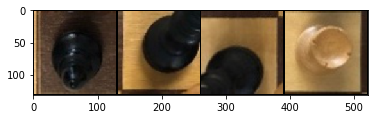

   Actual:     bb    bk    bq    wr
Predicted:     wp    wp    wp    wp


In [13]:
if __name__ == "__main__":
    main()
